In [49]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
# datapath='../../kaggle/jianhang/'

$\alpha$

本题属于分类任务，预测用户下周是否购买优惠券。

输出空间为{0,1}，0表示不买，1表示买。

输入空间为：
1. 用户ID、用户的30个隐私信息，存放在train_agg.csv文件，(80000,31)。
2. 用户的APP使用记录。80000个用户中，一部分绑定了APP，这是ta们的点击记录。存放在train_log.csv，(3533818，4)。

这80000个用户未来一周是否会买优惠券已经被标注好了，放在train_flg.csv，(8000,2)。需要利用这些已有数据(只能利用已有数据)，对20000个新的用户预测，对test_agg.csv和test_log.csv进行预测，提交格式为 test_result.csv，(20000，2)。


**流程：** 
* 度量标准：AUC
* 姑且按6:2:2一次性随机划定训练集，交叉验证集，测试集。
* 特征工程：大概是构建利用输入空间的34个特征来构建出更多地特征，然后在新构建出来的特征空间进行分类。
  * 有句话说，算法只是逼近特征工程的上限。所以就不断的随机无脑尝试各种特征的任意组合吧。
  * 但是好的算法，会自动寻找到不同特征之间的联系。比如用多元高斯分布进行异常检测，可以自动找到特征之间的线性关系。对于这个监督分类学习任务，目前想到的方法大概是：逻辑回归，线性svm，核svm，随机森林，协同过滤，各个模型集成。


**key:** 
* 对业务数据的理解。
* 对算法的理解。
* 会通过学习曲线评估算法，会误差分析，总之就是知道下一步怎么做。
* 动手能力。快速验证想法，好的工程溅射会使思维清晰快速。
* 努力程度。一千多支队伍想稳拿前十，得在一个月内大量尝试大量尝试，至少提交200个模型？(总共才300次提交机会)


疑问：就规模而言，数据量不大，居然能放进内存。这就不必考虑很多很多其它得事情了。奖励也挺好。接触ml已经有两个多月了。就学习进度上，是太慢了，主要是没有花费预想得足够多的时间。但是也有一些疑问。看过好些人的讨论，说是只会调用sklearn,tensorflow,numpy,等其它包不叫搞机器学习，看prml，西瓜书，推公式，也不叫机器学习，听公开课也不叫机器学习，真正的ml/dl只有ai专业出身的才算。也确实觉得，真正的工程项目，比如要部署在几百台机器上的数据，比如online模型，比如用C++把sklearn/tensorflow/pytorch的包重写一遍，这些硬工程能力很重要。但是既然招商银行说top10就可以给最终面试资格，而这个比赛，确实可以在普通PC上用4GB内存和i3处理器完成，就硬件来说连GPU都不需要。那么就一定要试一下 :)

# 加载数据：
提交格式：

In [17]:
submit_sample = pd.read_csv('submit_sample.csv',sep='\t')
print(submit_sample.shape)
submit_sample.head(5)

(20000, 2)


,USRID,RST
0,141,0
1,211,0
2,237,0
3,242,0
4,245,0


包含80000名信用卡客户的个人属性与信用卡消费数据，其中包含枚举型特征和数值型特征，均已转为数值并进行了脱敏和标准化处理。**个人属性与信用卡消费数据：**

In [24]:
train_agg = pd.read_csv('train_agg.csv',sep='\t')
print(train_agg.shape)
train_agg.head(5)

(80000, 31)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,USRID
0,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.70618,-0.29641,-0.18761,-0.48351,-0.53051,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.27221,-0.51336,-0.32438,14233
1,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.70618,0.37601,-0.10030,-0.16694,-0.31897,...,0.15815,-0.16201,0.4762,-0.50058,-0.77398,-0.25708,-0.37907,-0.52723,-0.32438,790
2,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.57176,0.03980,-0.17089,-0.38610,-0.46000,...,0.15815,-0.16201,0.4762,-0.55127,-0.77398,-0.25708,-0.57113,-0.54758,-0.32438,82308
3,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.30291,-0.29641,-0.18761,-0.45916,-0.53051,...,0.15815,-0.16201,0.4762,-0.26154,-0.77398,0.23440,-0.32873,-0.51951,-0.32438,90325
4,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.16849,-0.29641,-0.18761,-0.50786,-0.60103,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.54884,-0.32438,71893


In [25]:
train_agg.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,USRID
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,-0.001843,-0.001311,0.000629,0.001473,-0.000516,0.000663,0.000542,-0.001173,0.000695,0.001036,...,-0.000132,-0.000384,0.003030,-0.000797,-0.001609,0.001796,-0.001817,-0.001736,0.000157,49960.274863
std,0.971491,0.999873,1.000310,0.997673,0.999804,1.001168,1.009012,1.001755,1.005994,1.006116,...,0.972081,0.996350,0.998737,0.998908,0.991190,1.005999,0.992198,0.934959,1.019556,28863.537043
min,-1.925540,-0.906890,-1.266340,-3.457850,-0.684540,-1.840600,-81.658500,-10.745770,-2.626420,-2.152320,...,-0.779540,-0.798640,-66.324820,-0.559170,-0.773980,-0.508900,-21.583880,-0.859970,-1.132130,0.000000
25%,-0.420430,-0.906890,-0.378350,0.289200,-0.684540,-0.630800,-0.296410,-0.187610,-0.507860,-0.530510,...,-0.779540,-0.162010,0.001177,-0.556500,-0.263680,-0.257080,-0.570758,-0.479920,-0.324380,24882.750000
50%,-0.160930,-0.906890,-0.378350,0.289200,-0.684540,-0.227530,-0.296410,-0.187610,-0.410450,-0.365980,...,0.158150,-0.162010,0.349730,-0.417390,-0.263680,-0.257080,-0.397805,-0.303620,-0.324380,49943.500000
75%,0.124520,1.102660,-0.023160,0.289200,1.460830,0.444590,0.039800,-0.162300,0.027870,0.080600,...,0.158150,-0.162010,0.468992,0.072123,0.246620,-0.187180,0.104813,0.098350,0.079490,74976.250000
max,54.126760,1.102660,2.108010,0.289200,1.460830,7.703430,71.651890,66.949190,51.311760,48.734890,...,92.989580,45.945380,0.476200,12.483970,51.786890,36.857460,14.714840,28.502620,76.815630,99999.000000


上述信用卡客户(80000名)中，部分已绑定掌上生活APP的客户，在近一个月时间窗口内的所有点击行为日志。日志记录包含如下字段。**APP操作行为日志：**

In [33]:
train_log = pd.read_csv('train_log.csv',sep='\t')
print(train_log.shape)
train_log.head(5)

(3533818, 4)


,USRID,EVT_LBL,OCC_TIM,TCH_TYP
0,10002,163-577-913,2018-03-22 16:31:44,0
1,10002,163-578-914,2018-03-22 16:31:18,0
2,10002,259-924-1525,2018-03-22 16:31:15,0
3,10002,326-1040-1677,2018-03-06 12:08:51,0
4,10002,326-1041-1678,2018-03-09 14:40:22,0


EVT_LBL:点击模块名称，点击模块名称均为数字编码（形如231-145-18），代表了点击模块的三个级别。（如饭票-代金券-门店详情）

OCC_TIM:触发时间，用户触发该事件的精确时间。

TCH_TYP:事件类型，0:APP,1:WEB,2:H5

In [59]:
train_log.describe()

,USRID,TCH_TYP
count,3.533818e+06,3.533818e+06
mean,4.992006e+04,2.838290e-03
std,2.892967e+04,7.528961e-02
min,2.000000e+00,0.000000e+00
25%,2.463800e+04,0.000000e+00
50%,4.954000e+04,0.000000e+00
75%,7.505800e+04,0.000000e+00
max,9.999800e+04,2.000000e+00


In [86]:
train_log['TCH_TYP'].mean()

0.0028382899175905495

包括客户号及标签。其中，标签数据为用户是否会在未来一周，购买掌上生活APP上的优惠券。1表示购买，0表示未购买。**标注数据：**

In [30]:
train_flg = pd.read_csv('train_flg.csv',sep='\t')
print(train_flg.shape)
train_flg.head(5)

(80000, 2)


,USRID,FLAG
0,0,0
1,35,0
2,42,0
3,76,0
4,77,0


In [32]:
train_flg.describe()

,USRID,FLAG
count,80000.000000,80000.000000
mean,49960.274863,0.039700
std,28863.537043,0.195255
min,0.000000,0.000000
25%,24882.750000,0.000000
50%,49943.500000,0.000000
75%,74976.250000,0.000000
max,99999.000000,1.000000


In [39]:
test_agg = pd.read_csv('test_agg.csv',sep='\t')
print(test_agg.shape)
test_agg.head(5)

(20000, 31)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,USRID
0,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.03407,-0.29641,-0.18761,-0.50786,-0.60103,...,0.15815,-0.16201,0.4762,0.06979,-0.77398,-0.25708,-0.05001,-0.49396,-0.32438,92595
1,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.03407,0.03980,-0.13652,-0.48351,-0.55402,...,0.15815,-0.16201,0.4762,-0.39637,-0.77398,-0.25708,-0.42709,-0.54710,-0.32438,4572
2,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-0.09311,-0.29641,-0.18761,-0.33740,-0.46000,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.40814,-0.53054,-0.32438,64470
3,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,0.04132,-0.29641,-0.18761,-0.50786,-0.60103,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.54868,-0.32438,68958
4,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,0.04132,-0.29641,-0.18761,-0.48351,-0.53051,...,0.15815,-0.16201,0.4762,-0.06183,-0.77398,-0.25708,-0.16073,-0.54884,0.07949,8839


In [40]:
test_agg.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,USRID
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.007362,0.005245,-0.002513,-0.005880,0.002086,-0.002652,-0.002177,0.004701,-0.002786,-0.004144,...,0.000524,0.001533,-0.012117,0.003184,0.006422,-0.007170,0.007271,0.006945,-0.000616,50156.400550
std,1.106737,1.000520,0.998808,1.009286,1.000830,0.995360,0.963160,0.992984,0.975704,0.975194,...,1.104691,1.014516,1.004996,1.004403,1.034519,0.975647,1.030635,1.226159,0.917662,28884.324157
min,-1.925540,-0.906890,-1.266340,-3.457850,-0.684540,-1.840600,-1.305030,-0.245670,-0.824430,-0.859580,...,-0.779540,-0.581750,-19.085400,-0.559170,-0.773980,-0.967700,-2.622500,-0.568710,-0.728260,8.000000
25%,-0.394480,-0.906890,-0.378350,0.289200,-0.684540,-0.630800,-0.296410,-0.187610,-0.507860,-0.530510,...,-0.779540,-0.162010,-0.002580,-0.555573,-0.263680,-0.257080,-0.571253,-0.478820,-0.324380,25428.000000
50%,-0.160930,-0.906890,-0.378350,0.289200,-0.684540,-0.227530,-0.296410,-0.187610,-0.410450,-0.365980,...,0.158150,-0.162010,0.349920,-0.414640,-0.263680,-0.257080,-0.399690,-0.308030,-0.324380,50285.500000
75%,0.124520,1.102660,-0.023160,0.289200,1.460830,0.444590,0.039800,-0.158158,0.027870,0.080600,...,0.158150,-0.162010,0.469032,0.070020,0.246620,-0.187320,0.104170,0.102450,0.079490,75112.000000
max,52.907110,1.102660,2.108010,0.289200,1.460830,6.090350,48.453610,32.566140,17.171200,16.698280,...,71.422680,40.499950,0.476200,10.644780,62.503180,34.452210,16.481470,107.668410,33.601070,99997.000000


In [41]:
test_log = pd.read_csv('test_log.csv',sep='\t')
print(test_log.shape)
test_log.head(5)

(891414, 4)


,USRID,EVT_LBL,OCC_TIM,TCH_TYP
0,1000,162-574-910,2018-03-23 11:48:51,0
1,1000,257-922-1523,2018-03-14 13:31:01,0
2,1000,257-922-1523,2018-03-23 10:14:31,0
3,1000,257-922-1523,2018-03-23 11:46:23,0
4,1000,259-924-1525,2018-03-23 11:46:25,0


In [42]:
test_log.describe()

,USRID,TCH_TYP
count,891414.000000,891414.000000
mean,50490.885612,0.003334
std,28838.880804,0.081590
min,18.000000,0.000000
25%,25871.000000,0.000000
50%,50713.000000,0.000000
75%,75599.000000,0.000000
max,99972.000000,2.000000


In [47]:
print(train_agg.shape)# 个人属性与信用卡消费数据。
print(train_log.shape)# APP操作行为日志,带用户ID，远大于用户数量，因为一个用户不只使用一次。
print(train_flg.shape)# 标注数据，标注某用户ID在未来一周是否买优惠券。
print(test_agg.shape)# 测试数据，个人属性与信用卡消费数据。
print(test_log.shape)# 测试数据，APP操作行为日志。
print(submit_sample.shape)


(80000, 31)
(3533818, 4)
(80000, 2)
(20000, 31)
(891414, 4)
(20000, 2)


# 画图查看数据内部结构和关系：

In [70]:
np.arange(1,80001).sum()
# 太奇怪了！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！

-1094927296

In [71]:
train_agg['USRID'].sum()

3996821989

In [72]:
train_agg.ffill(0)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,USRID
0,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.70618,-0.29641,-0.18761,-0.48351,-0.53051,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.27221,-0.51336,-0.32438,14233
1,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.70618,0.37601,-0.10030,-0.16694,-0.31897,...,0.15815,-0.16201,0.4762,-0.50058,-0.77398,-0.25708,-0.37907,-0.52723,-0.32438,790
2,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.57176,0.03980,-0.17089,-0.38610,-0.46000,...,0.15815,-0.16201,0.4762,-0.55127,-0.77398,-0.25708,-0.57113,-0.54758,-0.32438,82308
3,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.30291,-0.29641,-0.18761,-0.45916,-0.53051,...,0.15815,-0.16201,0.4762,-0.26154,-0.77398,0.23440,-0.32873,-0.51951,-0.32438,90325
4,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.16849,-0.29641,-0.18761,-0.50786,-0.60103,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.54884,-0.32438,71893
5,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.16849,-0.29641,-0.18761,-0.50786,-0.60103,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.54884,-0.32438,83816
6,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.16849,-0.29641,-0.18761,-0.50786,-0.60103,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.54868,-0.32438,10878
7,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.16849,-0.29641,-0.18761,-0.50786,-0.60103,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.53480,-0.32438,80048
8,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.16849,-0.29641,-0.18761,-0.19129,-0.13094,...,0.15815,-0.16201,0.4762,0.00867,-0.77398,-0.17544,-0.08334,-0.49648,0.07949,45167
9,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.16849,-0.29641,-0.18761,-0.09389,-0.22495,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.37563,-0.53654,-0.32438,34303


In [74]:
train_agg.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,USRID
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,-0.001843,-0.001311,0.000629,0.001473,-0.000516,0.000663,0.000542,-0.001173,0.000695,0.001036,...,-0.000132,-0.000384,0.003030,-0.000797,-0.001609,0.001796,-0.001817,-0.001736,0.000157,49960.274863
std,0.971491,0.999873,1.000310,0.997673,0.999804,1.001168,1.009012,1.001755,1.005994,1.006116,...,0.972081,0.996350,0.998737,0.998908,0.991190,1.005999,0.992198,0.934959,1.019556,28863.537043
min,-1.925540,-0.906890,-1.266340,-3.457850,-0.684540,-1.840600,-81.658500,-10.745770,-2.626420,-2.152320,...,-0.779540,-0.798640,-66.324820,-0.559170,-0.773980,-0.508900,-21.583880,-0.859970,-1.132130,0.000000
25%,-0.420430,-0.906890,-0.378350,0.289200,-0.684540,-0.630800,-0.296410,-0.187610,-0.507860,-0.530510,...,-0.779540,-0.162010,0.001177,-0.556500,-0.263680,-0.257080,-0.570758,-0.479920,-0.324380,24882.750000
50%,-0.160930,-0.906890,-0.378350,0.289200,-0.684540,-0.227530,-0.296410,-0.187610,-0.410450,-0.365980,...,0.158150,-0.162010,0.349730,-0.417390,-0.263680,-0.257080,-0.397805,-0.303620,-0.324380,49943.500000
75%,0.124520,1.102660,-0.023160,0.289200,1.460830,0.444590,0.039800,-0.162300,0.027870,0.080600,...,0.158150,-0.162010,0.468992,0.072123,0.246620,-0.187180,0.104813,0.098350,0.079490,74976.250000
max,54.126760,1.102660,2.108010,0.289200,1.460830,7.703430,71.651890,66.949190,51.311760,48.734890,...,92.989580,45.945380,0.476200,12.483970,51.786890,36.857460,14.714840,28.502620,76.815630,99999.000000


# 构建训练集，交叉验证集，测试集：

In [188]:
from sklearn import linear_model, datasets, svm

In [876]:
train_agg = pd.read_csv('train_agg.csv',sep='\t')
train_log = pd.read_csv('train_log.csv',sep='\t')
train_flg = pd.read_csv('train_flg.csv',sep='\t')
test_agg = pd.read_csv('test_agg.csv',sep='\t')
test_log = pd.read_csv('test_log.csv',sep='\t')

In [691]:
print(train_agg.shape)# 个人属性与信用卡消费数据。
print(train_log.shape)# APP操作行为日志,带用户ID，远大于用户数量，因为一个用户不只使用一次。
print(train_flg.shape)# 标注数据，标注某用户ID在未来一周是否买优惠券。
print(test_agg.shape)# 测试数据，个人属性与信用卡消费数据。
print(test_log.shape)# 测试数据，APP操作行为日志。
print(submit_sample.shape)

(80000, 32)
(3533818, 4)
(80000, 2)
(20000, 31)
(891414, 4)
(20000, 2)


In [881]:
train_agg.index = train_agg['USRID']
train_log.index = train_log['USRID']
train_flg.index = train_flg['USRID']
test_agg.index = test_agg['USRID']
test_log.index = test_log['USRID']
train_agg.columns.name = 'feature'
train_log.columns.name = 'feature'
train_flg.columns.name = 'feature'
test_agg.columns.name = 'feature'
test_agg.columns.name = 'feature'


In [883]:
del train_agg['USRID']
del train_log['USRID']
del train_flg['USRID']
del test_agg['USRID']
del test_log['USRID']

In [912]:
train_agg.head()

feature,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
USRID,,,,,,,,,,,,,,,,,,,,,
14233,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.70618,-0.29641,-0.18761,-0.48351,-0.53051,...,-0.22881,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.27221,-0.51336,-0.32438
790,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.70618,0.37601,-0.10030,-0.16694,-0.31897,...,-0.22881,0.15815,-0.16201,0.4762,-0.50058,-0.77398,-0.25708,-0.37907,-0.52723,-0.32438
82308,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.57176,0.03980,-0.17089,-0.38610,-0.46000,...,-0.22881,0.15815,-0.16201,0.4762,-0.55127,-0.77398,-0.25708,-0.57113,-0.54758,-0.32438
90325,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.30291,-0.29641,-0.18761,-0.45916,-0.53051,...,-0.22881,0.15815,-0.16201,0.4762,-0.26154,-0.77398,0.23440,-0.32873,-0.51951,-0.32438
71893,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.16849,-0.29641,-0.18761,-0.50786,-0.60103,...,-0.22881,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.54884,-0.32438


In [900]:
who = pd.DataFrame(0*train_agg.index, index = train_agg.index, columns=['whopoint'])

In [901]:
whopoint = np.unique((train_log.index.values))

In [925]:
who.loc[whopoint] = 1

In [939]:
train_agg['whopoint'] = who.fillna(0)

In [ ]:
train_agg['flag'] = train_flg

In [947]:
train_agg

feature,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,V29,V30,whopoint,flag
USRID,,,,,,,,,,,,,,,,,,,,,
14233,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.70618,-0.29641,-0.18761,-0.48351,-0.53051,...,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.27221,-0.51336,-0.32438,1,0
790,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.70618,0.37601,-0.10030,-0.16694,-0.31897,...,-0.16201,0.4762,-0.50058,-0.77398,-0.25708,-0.37907,-0.52723,-0.32438,1,0
82308,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.57176,0.03980,-0.17089,-0.38610,-0.46000,...,-0.16201,0.4762,-0.55127,-0.77398,-0.25708,-0.57113,-0.54758,-0.32438,1,0
90325,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.30291,-0.29641,-0.18761,-0.45916,-0.53051,...,-0.16201,0.4762,-0.26154,-0.77398,0.23440,-0.32873,-0.51951,-0.32438,1,0
71893,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.16849,-0.29641,-0.18761,-0.50786,-0.60103,...,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.54884,-0.32438,1,0
83816,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.16849,-0.29641,-0.18761,-0.50786,-0.60103,...,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.54884,-0.32438,1,0
10878,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.16849,-0.29641,-0.18761,-0.50786,-0.60103,...,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.54868,-0.32438,1,0
80048,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.16849,-0.29641,-0.18761,-0.50786,-0.60103,...,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.53480,-0.32438,1,0
45167,-1.92554,-0.90689,-1.26634,0.28920,-0.68454,-1.16849,-0.29641,-0.18761,-0.19129,-0.13094,...,-0.16201,0.4762,0.00867,-0.77398,-0.17544,-0.08334,-0.49648,0.07949,1,0


In [950]:
train_agg.columns[0:31]

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30',
       'whopoint'],
      dtype='object', name='feature')

In [951]:
x = train_agg[train_agg.columns[0:31]].values

In [957]:
y = train_agg[train_agg.columns[31]].values

In [967]:
print(x[:,30].mean())
print(train_agg['whopoint'].mean())
print(y.mean())

0.48785
0.48785
0.0397


In [1041]:
x_train = x[0:60000]
x_test = x[60000:80000]
x_train.shape

(60000, 31)

In [1042]:
y_train = y[0:60000]
y_test = y[60000:80000]
y_train.shape

(60000,)

In [975]:
clf = linear_model.LogisticRegression(n_jobs=1,class_weight={1:25,0:1})
clf

LogisticRegression(C=1.0, class_weight={1: 25, 0: 1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [976]:
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight={1: 25, 0: 1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [977]:
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

0.6142833333333333
0.6168


In [1057]:
def sigma(x):
    return 1/(1 + np.exp(-x))

**计算AUC：**

In [1065]:
z = np.dot(x_train, clf.coef_.T) + clf.intercept_
print(z.shape)

(60000, 1)


In [1066]:
dataframe = pd.DataFrame(y_train, columns=['ytrue'])
dataframe['sigmaz'] = sigma(z)
dataframe.head()
# ytrain一栏，来自数据y_train，sigmaz一栏，来自分类器clf预测的概率值，clf的x_train用户ID和y_train一致可以直接并列。

,ytrue,sigmaz
0,0,0.615911
1,0,0.685665
2,0,0.659850
3,0,0.616753
4,0,0.623591


In [1067]:
sortbyprobability = dataframe.sort_values(by='sigmaz', ascending=False)['ytrue'].values
# 按sigmaz一栏从大到小排序，再取出排序之后的ytrain值
step = 100
# 按sigmaz排序后，
# 第一次认为前600个概率对应的用户ID会购买优惠卷，预测值存放在wethinktrue变量。
# 第二次认为前1200个概率对应的用户ID会购买优惠卷，预测值存放在wethinktrue变量。
searchrange = np.arange(0,len(y_train),step)
number = np.arange(len(searchrange))
# searchrange.shape
cache = np.arange(2*len(searchrange)).reshape(-1,2)
cache = cache * 0.0
print(cache.shape)
search = np.hstack(( number.reshape(-1,1), searchrange.reshape(-1,1) ))
print(search.shape)
wethinktrue = np.array([0] * len(y_train), dtype='int64')

(600, 2)
(600, 2)


In [1068]:
for choicenumber in search:
#     print(choicenumber)
    wethinktrue[0:choicenumber[1]] = 1
    TP = ((wethinktrue == 1 ) & (sortbyprobability == 1)).sum()
    FP = ((wethinktrue == 1 ) & (sortbyprobability == 0)).sum()
    FN = ((wethinktrue == 0 ) & (sortbyprobability == 1)).sum()
    TN = ((wethinktrue == 0 ) & (sortbyprobability == 0)).sum()
    FPR = FP/( TN +FP )
    TPR = TP/( TP + FN )
    cache[choicenumber[0]] = [FPR, TPR]
#     print(cache[choicenumber])
    

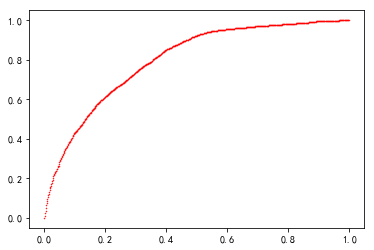

auc: 0.8004508535879629


In [1069]:
plt.plot(cache[:,0], cache[:,1], 'ro',markersize=0.5)
plt.show()
print('auc: ',end='')
print(np.diff(cache[:,0]).dot(cache[1:,1]))

**对测试集的效果：**

In [1152]:
z = np.dot(x_test, clf.coef_.T) + clf.intercept_
print(z.shape)

(20000, 1)


In [1153]:
dataframe = pd.DataFrame(y_test, columns=['ytrue'])
dataframe['sigmaz'] = sigma(z)
dataframe.head()

,ytrue,sigmaz
0,0,0.199281
1,0,0.722243
2,0,0.141608
3,0,0.678538
4,0,0.492434


In [1154]:
dataframe.count()

ytrue     20000
sigmaz    20000
dtype: int64

In [1155]:
sortbyprobability = dataframe.sort_values(by='sigmaz', ascending=False)['ytrue'].values
# 按sigmaz一栏从大到小排序，再取出排序之后的ytrain值
step = 100
# 按sigmaz排序后，
# 第一次认为前600个概率对应的用户ID会购买优惠卷，预测值存放在wethinktrue变量。
# 第二次认为前1200个概率对应的用户ID会购买优惠卷，预测值存放在wethinktrue变量。
searchrange = np.arange(0,len(y_test),step)
number = np.arange(len(searchrange))
# searchrange.shape
cache = np.arange(2*len(searchrange)).reshape(-1,2)
cache = cache * 0.0
print(cache.shape)
search = np.hstack(( number.reshape(-1,1), searchrange.reshape(-1,1) ))
print(search.shape)
wethinktrue = np.array([0] * len(y_test), dtype='int64')

(200, 2)
(200, 2)


In [1156]:
for choicenumber in search:
#     print(choicenumber)
    wethinktrue[0:choicenumber[1]] = 1
    TP = ((wethinktrue == 1 ) & (sortbyprobability == 1)).sum()
    FP = ((wethinktrue == 1 ) & (sortbyprobability == 0)).sum()
    FN = ((wethinktrue == 0 ) & (sortbyprobability == 1)).sum()
    TN = ((wethinktrue == 0 ) & (sortbyprobability == 0)).sum()
    FPR = FP/( TN +FP )
    TPR = TP/( TP + FN )
    cache[choicenumber[0]] = [FPR, TPR]
#     print(cache[choicenumber])

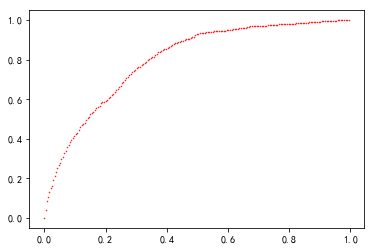

auc: 0.7976983104238259


In [1157]:
plt.plot(cache[:,0], cache[:,1], 'ro',markersize=0.5)
plt.show()
print('auc: ',end='')
print(np.diff(cache[:,0]).dot(cache[1:,1]))

http://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html
http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

# 提交的答案

In [1224]:
who = pd.DataFrame(0*test_agg.index, index = test_agg.index, columns=['whopoint'])
whopoint = np.unique((test_log.index.values))
who.loc[whopoint] = 1
test_agg['whopoint'] = who.fillna(0)
test_agg['flag'] = 0

In [1225]:
test_agg.head()

feature,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,V29,V30,whopoint,flag
USRID,,,,,,,,,,,,,,,,,,,,,
92595,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.03407,-0.29641,-0.18761,-0.50786,-0.60103,...,-0.16201,0.4762,0.06979,-0.77398,-0.25708,-0.05001,-0.49396,-0.32438,0,0
4572,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.03407,0.03980,-0.13652,-0.48351,-0.55402,...,-0.16201,0.4762,-0.39637,-0.77398,-0.25708,-0.42709,-0.54710,-0.32438,0,0
64470,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-0.09311,-0.29641,-0.18761,-0.33740,-0.46000,...,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.40814,-0.53054,-0.32438,1,0
68958,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,0.04132,-0.29641,-0.18761,-0.50786,-0.60103,...,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.54868,-0.32438,1,0
8839,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,0.04132,-0.29641,-0.18761,-0.48351,-0.53051,...,-0.16201,0.4762,-0.06183,-0.77398,-0.25708,-0.16073,-0.54884,0.07949,1,0


In [1226]:
submitx = test_agg[train_agg.columns[0:31]].values

In [1227]:
submitx.shape

(20000, 31)

In [1228]:
submitx[:,30].mean()

0.49235

In [1230]:
z = np.dot(submitx, clf.coef_.T) + clf.intercept_

In [1231]:
submity = sigma(z)

In [1232]:
submity.shape

(20000, 1)

In [1233]:
submity

array([[0.16010809],
       [0.18785899],
       [0.64851317],
       ...,
       [0.03127774],
       [0.02877644],
       [0.01553445]])

In [1234]:
test_agg['flag'] = submity

In [1235]:
test_agg['flag']

USRID
92595    0.160108
4572     0.187859
64470    0.648513
68958    0.636459
8839     0.627422
15106    0.174222
28227    0.183275
76977    0.677724
87072    0.504829
40428    0.111438
88271    0.111438
46501    0.500879
83325    0.509084
66548    0.112659
20169    0.508181
72567    0.511671
15100    0.513682
88834    0.583436
43478    0.530117
50283    0.515215
54729    0.515215
51280    0.115135
5185     0.517945
29181    0.514375
36725    0.515601
6332     0.519810
43184    0.116391
43492    0.519810
78130    0.519810
39970    0.540452
           ...   
43934    0.068836
65112    0.084041
5963     0.105147
14208    0.072488
34797    0.084178
60304    0.049230
48121    0.062102
93869    0.088119
1060     0.047054
36769    0.448519
4755     0.048022
29379    0.092292
91892    0.090688
55689    0.058733
70875    0.070105
26033    0.058335
36068    0.080616
33867    0.055544
526      0.459704
71111    0.060027
90564    0.066806
33337    0.283916
33728    0.054871
8618     0.040896
5289

In [1236]:
test_agg['flag'].to_csv('test_result.csv',sep='\t',index=True,header=False)